In [412]:
import numpy as np
import random
import itertools
import Levenshtein
import difflib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [430]:
class StringGenerator:

    def __init__(self, symbol_sets, len_seq, n_seq=6, n_rounds=1000):
        self.symbol_sets = symbol_sets
        self.len_seq = len_seq
        self.symbols = set.union(*symbol_sets)
        self.n_seq = n_seq
        self.n_rounds = n_rounds

    class Round:
        
        def __init__(self, symbol_sets, len_seq, n_seq=6):
            self.symbol_sets = symbol_sets
            self.len_seq = len_seq
            self.n_seq = n_seq
            self.sequences = self.round(n_seq)
            self.sequence_list = list(itertools.chain.from_iterable(self.sequences))
            self.pairs = list(itertools.combinations(self.sequence_list, 2))
            self.levenshtein = np.array([Levenshtein.distance(s1, s2) for s1, s2 in self.pairs])
            self.lcs = np.array([self.longest_common_substring(s1, s2) for s1, s2 in self.pairs])
            self.lcs_lengths = np.array([len(lcs) for lcs in self.lcs])

        @staticmethod
        def longest_common_substring(s1, s2):
            matcher = difflib.SequenceMatcher(None, s1, s2)
            match = matcher.find_longest_match(0, len(s1), 0, len(s2))
            return s1[match.a: match.a + match.size]

        def sequencer(self):
            permutations = ["".join(random.sample(list(symbol_set), self.len_seq)) for symbol_set in self.symbol_sets]
            return permutations
    
        def round(self, n_seq):
            sequences = []
            for _ in range(n_seq):
                sequences += [self.sequencer()]
            return sequences

    class Simulator:

        def __init__(self, parent, n_seq=6, n_rounds=1000):
            self.parent = parent
            self.n_seq = n_seq
            self.n_rounds = n_rounds
            self.levenshtein = None
            self.lcs = None
            self.lcs_length = None
            
        def run_simulation(self):
            all_levenshtein = []
            all_lcs = []
            all_lcs_length = []
            
            for _ in range(self.n_rounds):
                round_instance = self.parent.Round(self.parent.symbol_sets, self.parent.len_seq, self.n_seq)
                all_levenshtein.extend(round_instance.levenshtein)
                all_lcs.extend(round_instance.lcs)
                all_lcs_length.extend(round_instance.lcs_lengths)

            # Store the results as attributes of the instance
            self.levenshtein = np.array(all_levenshtein)
            self.lcs = np.array(all_lcs)
            self.lcs_lengths = np.array(all_lcs_length)


In [434]:
def plot_simulation(metric, type):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(metric, discrete=True, bins=int(max(metric)-min(metric)+1))  # Ensures discrete x-axis

    # Set x-axis ticks to integers
    ax.set_xticks(range(int(min(metric)), int(max(metric)) + 1))
    
    # Display count on top of each bar
    for patch in ax.patches:
        height = patch.get_height()
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2., height),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
    
    if type == 'ED':
        plt.xlabel("Levenshtein Distance", fontsize=14)
    elif type == 'LCS':
        plt.xlabel("Length of the Longest Common Substring", fontsize=14)
    
    plt.title("Distribution", fontsize=14)
    plt.show()

In [437]:
# Simulation

sets = [
    {'a','b','c','d'},
    {'c','d','e','f'},
    {'e','f','a','b'}
]

sg = StringGenerator(symbol_sets=sets, len_seq=4)
simulator = sg.Simulator(sg)
simulator.run_simulation()

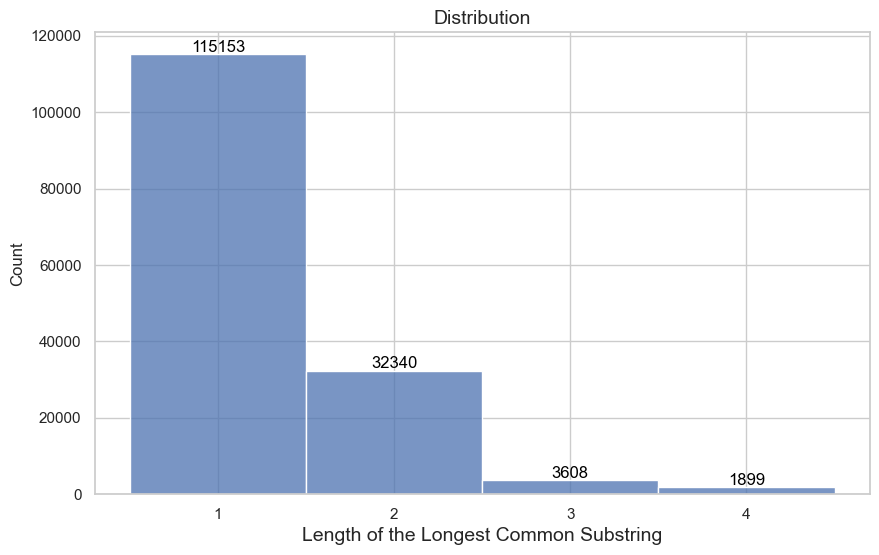

In [438]:
plot_simulation(simulator.lcs_lengths, 'LCS')